![](https://i.ibb.co/G0sLBVs/30-Days-ML-Hero.png). 


Machine learning beginner → Kaggle competitor in 30 days. Non-coders welcome.



The dataset is used for this competition is synthetic, but based on a real dataset. The original dataset deals with predicting the amount of an insurance claim. Although the features are anonymized, they have properties relating to real-world features.

## Загрузка

In [ ]:
from google.colab import files
files.upload()
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
kaggle.json


In [ ]:
! kaggle competitions download -c 30-days-of-ml -p /content/drive/My\Drive/kaggle/30_ML

 87% 22.0M/25.2M [00:01<00:00, 5.17MB/s]
100% 25.2M/25.2M [00:01<00:00, 16.8MB/s]
  0% 0.00/470k [00:00<?, ?B/s]
100% 470k/470k [00:00<00:00, 129MB/s]
 82% 33.0M/40.3M [00:03<00:01, 6.08MB/s]
100% 40.3M/40.3M [00:03<00:00, 13.8MB/s]


In [ ]:
%%capture
!pip install catboost

In [ ]:
%%capture
!pip install category_encoders

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV

import warnings

from sklearn.preprocessing import OrdinalEncoder 
from sklearn.preprocessing import LabelEncoder


from tensorflow import keras
from tensorflow.keras import layers, callbacks
from tensorflow.keras.callbacks import EarlyStopping
from keras import backend as K
from category_encoders import MEstimateEncoder

from scipy.stats import reciprocal, uniform

from catboost import CatBoostRegressor
from catboost import Pool
import lightgbm as lgb
from lightgbm import LGBMRegressor


warnings.filterwarnings("ignore")
sns.set_style("darkgrid")
%matplotlib inline


In [ ]:
train = pd.read_csv('/content/drive/MyDrive/kaggle/30_ML/train.csv.zip')
test = pd.read_csv('/content/drive/MyDrive/kaggle/30_ML/test.csv.zip')

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 26 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      300000 non-null  int64  
 1   cat0    300000 non-null  object 
 2   cat1    300000 non-null  object 
 3   cat2    300000 non-null  object 
 4   cat3    300000 non-null  object 
 5   cat4    300000 non-null  object 
 6   cat5    300000 non-null  object 
 7   cat6    300000 non-null  object 
 8   cat7    300000 non-null  object 
 9   cat8    300000 non-null  object 
 10  cat9    300000 non-null  object 
 11  cont0   300000 non-null  float64
 12  cont1   300000 non-null  float64
 13  cont2   300000 non-null  float64
 14  cont3   300000 non-null  float64
 15  cont4   300000 non-null  float64
 16  cont5   300000 non-null  float64
 17  cont6   300000 non-null  float64
 18  cont7   300000 non-null  float64
 19  cont8   300000 non-null  float64
 20  cont9   300000 non-null  float64
 21  cont10  30

In [ ]:
train.duplicated().sum()

0

## Подготовка

In [ ]:
nums = list(train.iloc[:, 11:25].columns)

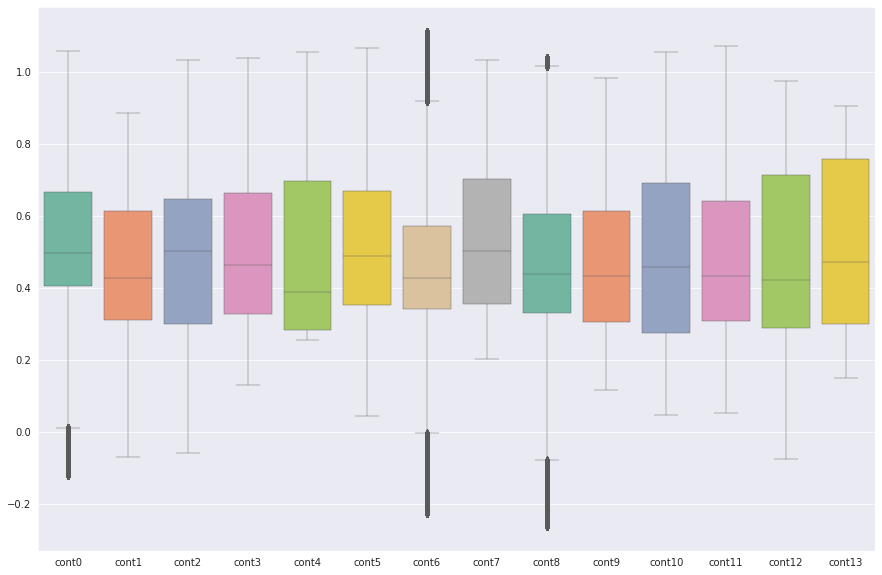

In [ ]:
cols = nums
plt.figure(figsize=(15,10))
sns.boxplot(data=train[cols], linewidth=0.42, palette="Set2")
plt.show()

In [ ]:
cols_clean = ['cont0', 'cont6', 'cont8']

low = .01
high = .99
quant_df = train[cols_clean].quantile([low, high])
df_clean = train[cols_clean].apply(lambda x: x[(x > quant_df.loc[low, x.name]) & 
                                     (x < quant_df.loc[high, x.name])], axis=0)
df_clean.dropna(inplace=True)
df_clean.head()



,cont0,cont6,cont8
0,0.201470,0.160266,0.389470
1,0.743068,0.558922,0.594928
2,0.742708,0.375348,0.555205
3,0.429551,0.239061,0.679618
5,0.402056,0.658169,0.569874


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 25 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      200000 non-null  int64  
 1   cat0    200000 non-null  object 
 2   cat1    200000 non-null  object 
 3   cat2    200000 non-null  object 
 4   cat3    200000 non-null  object 
 5   cat4    200000 non-null  object 
 6   cat5    200000 non-null  object 
 7   cat6    200000 non-null  object 
 8   cat7    200000 non-null  object 
 9   cat8    200000 non-null  object 
 10  cat9    200000 non-null  object 
 11  cont0   200000 non-null  float64
 12  cont1   200000 non-null  float64
 13  cont2   200000 non-null  float64
 14  cont3   200000 non-null  float64
 15  cont4   200000 non-null  float64
 16  cont5   200000 non-null  float64
 17  cont6   200000 non-null  float64
 18  cont7   200000 non-null  float64
 19  cont8   200000 non-null  float64
 20  cont9   200000 non-null  float64
 21  cont10  20

In [ ]:
train.head()

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,target
0,1,B,B,B,C,B,B,A,E,C,N,0.201470,-0.014822,0.669699,0.136278,0.610706,0.400361,0.160266,0.310921,0.389470,0.267559,0.237281,0.377873,0.322401,0.869850,8.113634
1,2,B,B,A,A,B,D,A,F,A,O,0.743068,0.367411,1.021605,0.365798,0.276853,0.533087,0.558922,0.516294,0.594928,0.341439,0.906013,0.921701,0.261975,0.465083,8.481233
2,3,A,A,A,C,B,D,A,D,A,F,0.742708,0.310383,-0.012673,0.576957,0.285074,0.650609,0.375348,0.902567,0.555205,0.843531,0.748809,0.620126,0.541474,0.763846,8.364351
3,4,B,B,A,C,B,D,A,E,C,K,0.429551,0.620998,0.577942,0.280610,0.284667,0.668980,0.239061,0.732948,0.679618,0.574844,0.346010,0.714610,0.540150,0.280682,8.049253
4,6,A,A,A,C,B,D,A,E,A,N,1.058291,0.367492,-0.052389,0.232407,0.287595,0.686964,0.420667,0.648182,0.684501,0.956692,1.000773,0.776742,0.625849,0.250823,7.972260


In [ ]:
test.head()

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13
0,0,B,B,B,C,B,B,A,E,E,I,0.296227,0.686757,0.587731,0.392753,0.476739,0.376350,0.337884,0.321832,0.445212,0.290258,0.244476,0.087914,0.301831,0.845702
1,5,A,B,A,C,B,C,A,E,C,H,0.543707,0.364761,0.452967,0.929645,0.285509,0.860046,0.798712,0.835961,0.391657,0.288276,0.549568,0.905097,0.850684,0.693940
2,15,B,A,A,A,B,B,A,E,D,K,0.408961,0.296129,0.690999,0.740027,0.697272,0.683600,0.404089,0.879379,0.275549,0.427871,0.491667,0.384315,0.376689,0.508099
3,16,B,B,A,C,B,D,A,E,A,N,1.031239,0.356062,0.303651,0.895591,0.719306,0.777890,0.730954,0.644315,1.024017,0.391090,0.988340,0.411828,0.393585,0.461372
4,17,B,B,A,C,B,C,A,E,C,F,0.530447,0.729004,0.281723,0.444698,0.313032,0.431007,0.390992,0.408874,0.447887,0.390253,0.648932,0.385935,0.370401,0.900412


In [ ]:
train.columns

Index(['id', 'cat0', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7',
       'cat8', 'cat9', 'cont0', 'cont1', 'cont2', 'cont3', 'cont4', 'cont5',
       'cont6', 'cont7', 'cont8', 'cont9', 'cont10', 'cont11', 'cont12',
       'cont13', 'target'],
      dtype='object')

In [ ]:
def split_data(data, target_column):
    return data.drop(columns=[target_column], axis=1), data[target_column]

In [ ]:
features, target = split_data(train, 'target')

In [ ]:
features.head()

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13
0,1,B,B,B,C,B,B,A,E,C,N,0.201470,-0.014822,0.669699,0.136278,0.610706,0.400361,0.160266,0.310921,0.389470,0.267559,0.237281,0.377873,0.322401,0.869850
1,2,B,B,A,A,B,D,A,F,A,O,0.743068,0.367411,1.021605,0.365798,0.276853,0.533087,0.558922,0.516294,0.594928,0.341439,0.906013,0.921701,0.261975,0.465083
2,3,A,A,A,C,B,D,A,D,A,F,0.742708,0.310383,-0.012673,0.576957,0.285074,0.650609,0.375348,0.902567,0.555205,0.843531,0.748809,0.620126,0.541474,0.763846
3,4,B,B,A,C,B,D,A,E,C,K,0.429551,0.620998,0.577942,0.280610,0.284667,0.668980,0.239061,0.732948,0.679618,0.574844,0.346010,0.714610,0.540150,0.280682
4,6,A,A,A,C,B,D,A,E,A,N,1.058291,0.367492,-0.052389,0.232407,0.287595,0.686964,0.420667,0.648182,0.684501,0.956692,1.000773,0.776742,0.625849,0.250823


In [ ]:
features.columns

Index(['id', 'cat0', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7',
       'cat8', 'cat9', 'cont0', 'cont1', 'cont2', 'cont3', 'cont4', 'cont5',
       'cont6', 'cont7', 'cont8', 'cont9', 'cont10', 'cont11', 'cont12',
       'cont13'],
      dtype='object')

In [ ]:
features = features.drop(['id'], axis=1)

In [ ]:
float_num = list(features.select_dtypes(include='float64'))

In [ ]:
features[float_num].head()

,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13
0,0.201470,-0.014822,0.669699,0.136278,0.610706,0.400361,0.160266,0.310921,0.389470,0.267559,0.237281,0.377873,0.322401,0.869850
1,0.743068,0.367411,1.021605,0.365798,0.276853,0.533087,0.558922,0.516294,0.594928,0.341439,0.906013,0.921701,0.261975,0.465083
2,0.742708,0.310383,-0.012673,0.576957,0.285074,0.650609,0.375348,0.902567,0.555205,0.843531,0.748809,0.620126,0.541474,0.763846
3,0.429551,0.620998,0.577942,0.280610,0.284667,0.668980,0.239061,0.732948,0.679618,0.574844,0.346010,0.714610,0.540150,0.280682
4,1.058291,0.367492,-0.052389,0.232407,0.287595,0.686964,0.420667,0.648182,0.684501,0.956692,1.000773,0.776742,0.625849,0.250823


In [ ]:
kmeans = KMeans(n_clusters=6)
features["Cluster"] = kmeans.fit_predict(features[float_num])
features["Cluster"] = features["Cluster"].astype("category")

In [ ]:
X_train, X_val, y_train, y_val = ( 
                                train_test_split(
                                features, target, test_size=0.25, random_state=42)
)


In [ ]:
X_train[nums].shape

(225000, 14)

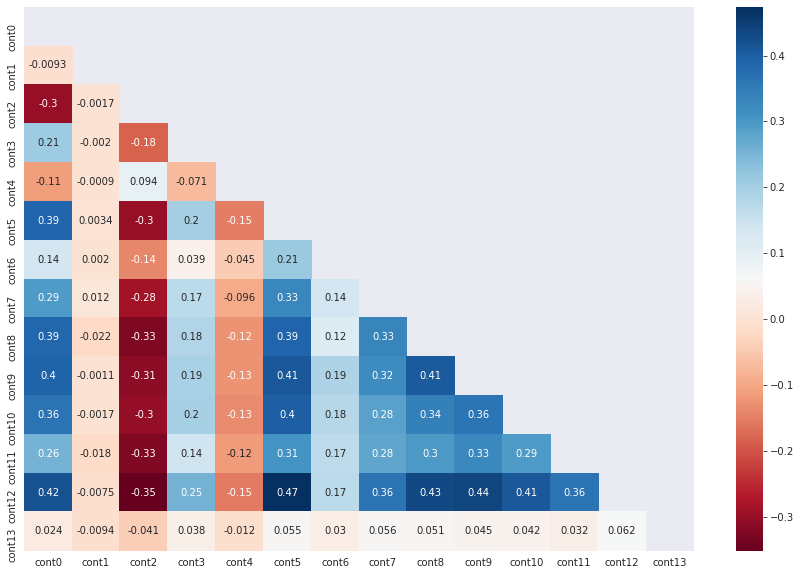

In [ ]:
plt.figure(figsize=(15,10))
mask = np.triu(np.ones_like(X_train[nums].corr()))
sns.heatmap(X_train[nums].corr(), annot=True, mask=mask, cmap="RdBu");

In [ ]:
X_train_clean = X_train[X_train.index.isin(df_clean.index)]
X_val_clean = X_val[X_val.index.isin(df_clean.index)]
y_train_clean = y_train[y_train.index.isin(df_clean.index)]
y_val_clean = y_val[y_val.index.isin(df_clean.index)]
X_train_clean.shape, X_val_clean.shape, y_train_clean.shape, y_val_clean.shape

In [ ]:
X_train.shape

(225000, 25)

In [ ]:
cat_feature = list(X_train.select_dtypes(include=['object', 'category']))
cat_feature 

['cat0',
 'cat1',
 'cat2',
 'cat3',
 'cat4',
 'cat5',
 'cat6',
 'cat7',
 'cat8',
 'cat9',
 'Cluster']

## LGBM с CV prediction

In [ ]:
# gbm_features = list(X_train.columns)
# X_train_gbm = X_train_clean.copy()



# for cat in cat_feature:
#     X_train_gbm[cat_feature] = X_train_gbm[cat_feature].astype('category')

# train_data = lgb.Dataset ( X_train_gbm , label = y_train_clean, feature_name = gbm_features ,
#                            categorical_feature = cat_feature, free_raw_data=False
#                            )

# формирование сета данных для модели


# lgbm_params =  {
#     'task': 'train',
#     'boosting_type': 'gbdt',
#     'objective': 'regression',
#     'metric': 'rmse',
#     "learning_rate": 0.02,
#     "num_leaves": 20,
#     "feature_fraction": 0.5,
#     "bagging_fraction": 0.5,
#     'bagging_freq': 100,
#     "reg_alpha": 0.5,
#     "reg_lambda": 0.5,
#     'zero_as_missing':True
#                 }

# lgbm_params =  {
#     'task': 'train',
#     'boosting_type': 'gbdt',
#     'objective': 'regression',
#     'metric': 'rmse',
#     "learning_rate": 0.008,
#     "num_leaves": 111,
#     "min_child_samples": 285,
#     "subsample": 0.8,
#     'max_depth': 20,
#     "reg_alpha": 6.15,
#     "reg_lambda": 0.002,
#     'colsample_bytree': 0.3,
#     'n_estimators':2000,
#     'cat_smooth':42,
#     'random_state':42
#                 }

# lgbm_params =  {
#     'task': 'train',
#     'boosting_type': 'gbdt',
#     'objective': 'regression',
#     'metric': 'rmse',
#     "learning_rate": 0.008,
#     "num_leaves": 100,
#     "min_child_samples": 256,
#     "subsample": 0.8,
#     'max_depth': 20,
#     "reg_alpha": 6.15,
#     "reg_lambda": 0.002,
#     'colsample_bytree': 0.3,
#     'n_estimators':20000,
#     'cat_smooth':42,
#     'random_state':42
#                 }



#### lgbm_params = {
#     "boosting_type": "gbdt",
#     "objective": "regression",
#     "metric": "rmse",
#     "learning_rate": 0.008,
#     "num_leaves": 77,
#     "max_depth": 77,
#     "feature_fraction": 0.225,
#     "bagging_fraction": 0.771,
#     "min_child_samples": 290,
#     "reg_alpha": 9.42,
#     "reg_lambda": 9.42,
#     "max_bin": 772,
#     "min_data_per_group": 177,
#     "bagging_freq": 1,
#     "cat_smooth": 96,
#     "cat_l2": 17,
#     "verbosity": -1,
#     "bagging_seed": 42,
#     "feature_fraction_seed": 42,
#     "seed": 42,
#     'num_boost_round': 100000
# }


# lgbm_params = {'n_estimators': 10000,
#               'learning_rate': 0.35,
#               'subsample': 0.926,
#               'colsample_bytree': 0.84,
#               'max_depth': 2,
#               'booster': 'gbdt', 
#               'reg_lambda': 35.1,
#               'reg_alpha': 34.9,
#               'random_state': 42,
#               'n_jobs': 4}




# lgbm_params = {
#     "boosting_type": "gbdt",
#     "objective": "regression",
#     "metric": "rmse",
#     "learning_rate": 0.008,
#     "num_leaves": 77,
#     "max_depth": 77,
#     "feature_fraction": 0.225,
#     "bagging_fraction": 0.771,
#     "min_child_samples": 290,
#     "reg_alpha": 35.3,
#     "reg_lambda": 35.1,
#     "max_bin": 772,
#     "min_data_per_group": 177,
#     "bagging_freq": 1,
#     "cat_smooth": 96,
#     "cat_l2": 10,
#     "verbosity": -1,
#     "bagging_seed": 42,
#     "feature_fraction_seed": 42,
#     "seed": 42,
#     'num_boost_round': 100000,
#     'colsample_bytree': 0.84
# }





# lgb_cv = lgb.cv(
#     params = lgbm_params,
#     train_set = train_data,
#     num_boost_round=5000,
#     stratified=False,
#     nfold = 5,
#     verbose_eval=100,
#     seed = 42,
#     early_stopping_rounds=500)




In [ ]:
X_test = test.drop(['id'], axis=1)

In [ ]:
# train_data = lgb.Dataset ( X_train_gbm , label = y_train_clean , feature_name = gbm_features ,
#                            categorical_feature = cat_feature, free_raw_data=False
#                            )

In [ ]:
# num_round = 3000
# lgb_model = lgb.train(lgbm_params, train_data, num_round)

In [ ]:
# X_val_gbm = X_val_clean.copy()



# for cat in cat_feature:
#     X_val_gbm[cat_feature] = X_val_gbm[cat_feature].astype('category')

# y_pred = lgb_model.predict(X_val_gbm)
# rmse = (mean_squared_error(y_val_clean, y_pred)) ** 0.5
# rmse

In [ ]:
# lgb.plot_importance(lgb_model, figsize = (12, 5))
# plt.show()

In [ ]:
# cat_feature = list(X_train.select_dtypes(include=['object', 'category']))
# cat_feature 

## LGBM с GS и CV

In [ ]:
features, target = split_data(train, 'target')

In [ ]:
features.shape

(300000, 25)

In [ ]:
cat_feature = list(features.select_dtypes(include=['object']))
cat_feature 

[]

In [ ]:
encoder = OrdinalEncoder()


In [ ]:
features[cat_feature] = encoder.fit_transform(features[cat_feature])

In [ ]:
features.head()

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13
0,1,1.0,1.0,1.0,2.0,1.0,1.0,0.0,4.0,2.0,13.0,0.201470,-0.014822,0.669699,0.136278,0.610706,0.400361,0.160266,0.310921,0.389470,0.267559,0.237281,0.377873,0.322401,0.869850
1,2,1.0,1.0,0.0,0.0,1.0,3.0,0.0,5.0,0.0,14.0,0.743068,0.367411,1.021605,0.365798,0.276853,0.533087,0.558922,0.516294,0.594928,0.341439,0.906013,0.921701,0.261975,0.465083
2,3,0.0,0.0,0.0,2.0,1.0,3.0,0.0,3.0,0.0,5.0,0.742708,0.310383,-0.012673,0.576957,0.285074,0.650609,0.375348,0.902567,0.555205,0.843531,0.748809,0.620126,0.541474,0.763846
3,4,1.0,1.0,0.0,2.0,1.0,3.0,0.0,4.0,2.0,10.0,0.429551,0.620998,0.577942,0.280610,0.284667,0.668980,0.239061,0.732948,0.679618,0.574844,0.346010,0.714610,0.540150,0.280682
4,6,0.0,0.0,0.0,2.0,1.0,3.0,0.0,4.0,0.0,13.0,1.058291,0.367492,-0.052389,0.232407,0.287595,0.686964,0.420667,0.648182,0.684501,0.956692,1.000773,0.776742,0.625849,0.250823


In [ ]:
features = features.drop('id', axis=1)

In [ ]:
params = {"learning_rate": [0.003899, 0.008, 0.35],
              "num_leaves": [62, 77]}




params_lgb = {
    "task": "train",
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": "rmse",
    "max_depth": 95,
    "feature_fraction": 0.2256,
    "bagging_fraction": 0.8805,
    "min_child_samples": 290,
    "reg_alpha": 9.562925,
    "reg_lambda": 9.35581,
    "max_bin": 881,
    "min_data_per_group": 125,
    "bagging_freq": 1,
    "cat_smooth": 96,
    "cat_l2": 19,
    "verbosity": -1,
    "bagging_seed": 42,
    "feature_fraction_seed": 42,
    "seed": 42
}
model = LGBMRegressor(random_state=42, **params_lgb)

grid = GridSearchCV(model, params, 
                    scoring='r2', cv=5)

In [ ]:
# grid.fit(features, target)

GridSearchCV(cv=5, error_score=nan,
             estimator=LGBMRegressor(bagging_fraction=0.8805, bagging_freq=1,
                                     bagging_seed=42, boosting_type='gbdt',
                                     cat_l2=19, cat_smooth=96,
                                     class_weight=None, colsample_bytree=1.0,
                                     feature_fraction=0.2256,
                                     feature_fraction_seed=42,
                                     importance_type='split', learning_rate=0.1,
                                     max_bin=881, max_depth=95, metric='rmse',
                                     min_child_samples=290,
                                     m...
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     objective='regression', random_state=42,
                                     reg_alpha=9.562925, reg_lambda=9.35581,
                                     seed=42, 

In [ ]:
lgbm_tuned = grid.best_estimator_

In [ ]:
X_test_cv = X_test.copy()

X_test_cv[cat_feature] = encoder.transform(X_test_cv[cat_feature])

In [ ]:
# X_test["Cluster"] = kmeans.predict(X_test[float_num])
# X_test["Cluster"] = X_test["Cluster"].astype("category")

# X_test_gbm = X_test.copy()

In [ ]:
preds = np.zeros(test.shape[0])
kf = KFold(n_splits=5, random_state=42, shuffle=True)
rmse=[]
n=0


for train_idx, test_idx in kf.split(features, target):

    X_train_g, X_val_g = features.iloc[train_idx], features.iloc[test_idx]
    y_tr_g, y_val_g = target.iloc[train_idx], target.iloc[test_idx]





    model = LGBMRegressor(**lgbm_params)

    model.fit(X_train_g, y_tr_g, eval_set = [(X_val_g, y_val_g)],
              early_stopping_rounds=200,verbose=False)
    

    preds += model.predict(X_test_cv)/kf.n_splits

    rmse.append(mean_squared_error(y_val_g, model.predict(X_val_g), squared=False))
    print(n+1,rmse[n])
    n+=1

1 0.7201913732657195
2 0.7198413046481426
3 0.721691343092229
4 0.7212107743268916
5 0.7207240903325187


1 0.7195126241945157.  
2 0.7210475109871509.  
3 0.7188888805297217.  
4 0.7192378725031316.  
5 0.7152799830372809.  


In [ ]:

# for cat in cat_feature:
#     X_test_gbm[cat] = X_test_gbm[cat].astype('category')



# ypred = lgb_model.predict(X_test_gbm)


In [ ]:
test_id = test['id']

In [ ]:
# sub = pd.DataFrame()
# sub['Id'] = test_id
# sub['target'] = ypred
# sub.to_csv('my_submission_lgbm.csv',index=False)
# from google.colab import files
# # files.download("my_submission_lgbm.csv")

In [ ]:
# sub = pd.DataFrame()
# sub['Id'] = test_id
# sub['target'] = preds
# sub.to_csv('my_submission_lgbm_CV.csv',index=False)
# from google.colab import files
# files.download("my_submission_lgbm_CV.csv")

In [ ]:
# sub = pd.DataFrame()
# sub['Id'] = test_id
# sub['target'] = preds
# sub.to_csv('my_submission_lgbm_CV_new.csv',index=False)
# from google.colab import files
# files.download("my_submission_lgbm_CV_new.csv")

In [ ]:
sub = pd.DataFrame()
sub['Id'] = test_id
sub['target'] = preds
sub.to_csv('my_submission_lgbm_CGV_new_param.csv',index=False)
from google.colab import files
# files.download("my_submission_lgbm_CGV_new_param.csv")

In [ ]:
# sub = pd.DataFrame()
# sub['Id'] = test_id
# sub['target'] = preds
# sub.to_csv('my_submission_lgbm_CV_XG.csv',index=False)
# from google.colab import files
# files.download("my_submission_lgbm_CV_XG.csv")

In [ ]:
# sub = pd.DataFrame()
# sub['Id'] = test_id
# sub['target'] = preds
# sub.to_csv('my_submission_lgbm_CV_Clean.csv',index=False)
# from google.colab import files
# files.download("my_submission_lgbm_CV_Clean.csv")

In [ ]:
sub.head()

,Id,target
0,0,8.088469
1,5,8.255259
2,15,8.412655
3,16,8.465137
4,17,8.146321


## LGBM with labeling

In [ ]:
#"my_submission_lgbm_CGV_new_param.csv"
params_lgb = {
    "task": "train",
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": "rmse",
    "learning_rate": 0.003899,
    'num_boost_round': 100000,
    "num_leaves": 62,
    "max_depth": 95,
    "feature_fraction": 0.2256,
    "bagging_fraction": 0.8805,
    "min_child_samples": 290,
    "reg_alpha": 9.562925,
    "reg_lambda": 9.35581,
    "max_bin": 881,
    "min_data_per_group": 125,
    "bagging_freq": 1,
    "cat_smooth": 96,
    "cat_l2": 19,
    "verbosity": -1,
    "bagging_seed": 42,
    "feature_fraction_seed": 42,
    "seed": 42
}


#my_submission_lgbm_label_0.008
# params_lgb = {

#     "boosting_type": "gbdt",
#     "objective": "regression",
#     "metric": "rmse",
#     'num_boost_round': 100000,
#     "learning_rate": 0.008,
#     "num_leaves": 62,
#     "max_depth": 95,
#     "feature_fraction": 0.2256,
#     "bagging_fraction": 0.8805,
#     "min_child_samples": 290,
#     "reg_alpha": 9.562925,
#     "reg_lambda": 9.35581,
#     "max_bin": 881,
#     "min_data_per_group": 125,
#     "bagging_freq": 1,
#     "cat_smooth": 96,
#     "cat_l2": 19,
#     "verbosity": -1,
#     "bagging_seed": 42,
#     "feature_fraction_seed": 42,
#     "seed": 42,
#     'n_jobs': 4
# }

#my_submission_lgbm_label_0.008-77
# params_lgb = {
#     "boosting_type": "gbdt",
#     "objective": "regression",
#     "metric": "rmse",
#     "learning_rate": 0.008,
#     "num_leaves": 77,
#     "max_depth": 77,
#     "feature_fraction": 0.225,
#     "bagging_fraction": 0.771,
#     "min_child_samples": 290,
#     "reg_alpha": 35.3,
#     "reg_lambda": 35.1,
#     "max_bin": 772,
#     "min_data_per_group": 177,
#     "bagging_freq": 1,
#     "cat_smooth": 96,
#     "cat_l2": 10,
#     "verbosity": -1,
#     "bagging_seed": 42,
#     "feature_fraction_seed": 42,
#     "seed": 42,
#     'num_boost_round': 100000,
#     'colsample_bytree': 0.84,
#     'n_jobs': 4
# }


In [ ]:
X_encode, y_encode = split_data(train, 'target')

In [ ]:
X_encode = X_encode.drop('id', axis=1)

In [ ]:
X_en = X_encode.sample(frac=0.25)
y_en = y_encode[X_en.index]
X_pretrain = X_encode.drop(X_en.index)
y_train = y_encode[X_pretrain.index]

In [ ]:
encoder_1 = MEstimateEncoder(cols=["cat9"], m=4.0)
encoder_1.fit(X_encode, y_encode)

X_train = encoder_1.transform(X_pretrain)



In [ ]:
features = X_train.copy()
target = y_train

In [ ]:
features.shape

(225000, 24)

In [ ]:
cat_feature = list(features.select_dtypes(include=['object']))
cat_feature 

['cat0', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8']

In [ ]:
encoder = OrdinalEncoder()


In [ ]:
features[cat_feature] = encoder.fit_transform(features[cat_feature])

In [ ]:
features.head()

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13
0,1.0,1.0,1.0,2.0,1.0,1.0,0.0,4.0,2.0,8.249952,0.201470,-0.014822,0.669699,0.136278,0.610706,0.400361,0.160266,0.310921,0.389470,0.267559,0.237281,0.377873,0.322401,0.869850
1,1.0,1.0,0.0,0.0,1.0,3.0,0.0,5.0,0.0,8.240612,0.743068,0.367411,1.021605,0.365798,0.276853,0.533087,0.558922,0.516294,0.594928,0.341439,0.906013,0.921701,0.261975,0.465083
2,0.0,0.0,0.0,2.0,1.0,3.0,0.0,3.0,0.0,8.259044,0.742708,0.310383,-0.012673,0.576957,0.285074,0.650609,0.375348,0.902567,0.555205,0.843531,0.748809,0.620126,0.541474,0.763846
3,1.0,1.0,0.0,2.0,1.0,3.0,0.0,4.0,2.0,8.269889,0.429551,0.620998,0.577942,0.280610,0.284667,0.668980,0.239061,0.732948,0.679618,0.574844,0.346010,0.714610,0.540150,0.280682
4,0.0,0.0,0.0,2.0,1.0,3.0,0.0,4.0,0.0,8.249952,1.058291,0.367492,-0.052389,0.232407,0.287595,0.686964,0.420667,0.648182,0.684501,0.956692,1.000773,0.776742,0.625849,0.250823


In [ ]:
features.dtypes

cat0      float64
cat1      float64
cat2      float64
cat3      float64
cat4      float64
cat5      float64
cat6      float64
cat7      float64
cat8      float64
cat9      float64
cont0     float64
cont1     float64
cont2     float64
cont3     float64
cont4     float64
cont5     float64
cont6     float64
cont7     float64
cont8     float64
cont9     float64
cont10    float64
cont11    float64
cont12    float64
cont13    float64
dtype: object

In [ ]:
X_test = test.drop(['id'], axis=1)

X_test_cv_1 = X_test.copy()
X_test_cv = encoder_1.transform(X_test_cv_1)
X_test_cv[cat_feature] = encoder.transform(X_test_cv[cat_feature])

In [ ]:
preds = np.zeros(test.shape[0])
kf = KFold(n_splits=5, random_state=42, shuffle=True)
rmse=[]
n=0

for train_idx, test_idx in kf.split(features, target):

    X_train_g, X_val_g = features.iloc[train_idx], features.iloc[test_idx]
    y_tr_g, y_val_g = target.iloc[train_idx], target.iloc[test_idx]

    model = LGBMRegressor(**params_lgb)
    model.fit(X_train_g, y_tr_g, eval_set = [(X_val_g, y_val_g)],
              early_stopping_rounds=200,verbose=False)
    

    preds += model.predict(X_test_cv)/kf.n_splits
    rmse.append(mean_squared_error(y_val_g, model.predict(X_val_g), 
                                   squared=False))
    print(n+1,rmse[n])
    n+=1

1 0.7227393507652368
2 0.7163609635789291
3 0.7158938462965407
4 0.7173986634697292
5 0.717332459966237


In [ ]:
preds

array([8.04922993, 8.35047868, 8.44423928, ..., 8.50515574, 8.13254779,
       8.00392631])

In [ ]:
sub = pd.DataFrame()
sub['Id'] = test_id
sub['target'] = preds
sub.to_csv('my_submission_lgbm_wolabel_0.003DR.csv',index=False)
# from google.colab import files

In [ ]:
preds_label = pd.Series(preds)

In [ ]:
preds_label[:5]

0    8.049230
1    8.350479
2    8.444239
3    8.500391
4    8.152910
dtype: float64

In [ ]:
X = pd.concat([features, X_test_cv], axis=0).reset_index(drop=True)
y = pd.concat([target, preds_label], axis=0).reset_index(drop=True)

print("X.shape: ", X.shape)
print("y.shape: ", y.shape)

X.shape:  (425000, 24)
y.shape:  (425000,)


In [ ]:
X.head()

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13
0,1.0,1.0,1.0,2.0,1.0,1.0,0.0,4.0,2.0,8.249952,0.201470,-0.014822,0.669699,0.136278,0.610706,0.400361,0.160266,0.310921,0.389470,0.267559,0.237281,0.377873,0.322401,0.869850
1,1.0,1.0,0.0,0.0,1.0,3.0,0.0,5.0,0.0,8.240612,0.743068,0.367411,1.021605,0.365798,0.276853,0.533087,0.558922,0.516294,0.594928,0.341439,0.906013,0.921701,0.261975,0.465083
2,0.0,0.0,0.0,2.0,1.0,3.0,0.0,3.0,0.0,8.259044,0.742708,0.310383,-0.012673,0.576957,0.285074,0.650609,0.375348,0.902567,0.555205,0.843531,0.748809,0.620126,0.541474,0.763846
3,1.0,1.0,0.0,2.0,1.0,3.0,0.0,4.0,2.0,8.269889,0.429551,0.620998,0.577942,0.280610,0.284667,0.668980,0.239061,0.732948,0.679618,0.574844,0.346010,0.714610,0.540150,0.280682
4,0.0,0.0,0.0,2.0,1.0,3.0,0.0,4.0,0.0,8.249952,1.058291,0.367492,-0.052389,0.232407,0.287595,0.686964,0.420667,0.648182,0.684501,0.956692,1.000773,0.776742,0.625849,0.250823


In [ ]:
preds = np.zeros(test.shape[0])
kf = KFold(n_splits=5, random_state=42, shuffle=True)
rmse=[]
n=0

for train_idx, test_idx in kf.split(X, y):

    X_train_g, X_val_g = X.iloc[train_idx], X.iloc[test_idx]
    y_tr_g, y_val_g = y.iloc[train_idx], y.iloc[test_idx]

    model = LGBMRegressor(**params_lgb)
    model.fit(X_train_g, y_tr_g, eval_set = [(X_val_g, y_val_g)],
              early_stopping_rounds=200,verbose=False)
    

    preds += model.predict(X_test_cv)/kf.n_splits
    rmse.append(mean_squared_error(y_val_g, model.predict(X_val_g), 
                                   squared=False))
    print(n+1,rmse[n])
    n+=1


1 0.5226563114681195
2 0.5185047048153425
3 0.5192669827472048
4 0.5201421335687793
5 0.5224300456105727


1 0.7166541135702886.  
2 0.7167587046434112.  
3 0.7185340457413194.  
4 0.7184551586950905.  
5 0.7169656524800676.  

In [ ]:
# sub = pd.DataFrame()
# sub['Id'] = test_id
# sub['target'] = preds
# sub.to_csv('my_submission_lgbm_label_0.003.csv',index=False)

In [ ]:
sub = pd.DataFrame()
sub['Id'] = test_id
sub['target'] = preds
sub.to_csv('my_submission_lgbm_label_0.003DR.csv',index=False)

In [ ]:
# sub = pd.DataFrame()
# sub['Id'] = test_id
# sub['target'] = preds
sub.to_csv('my_submission_lgbm_label_0.008-77.csv',index=False)

In [ ]:
sub.head()

,Id,target
0,0,8.055925
1,5,8.352449
2,15,8.420666
3,16,8.493415
4,17,8.153562


## Catboost с СV

In [ ]:
# X_train_cat = features[features.index.isin(df_clean.index)]
# y_train_cat = target[target.index.isin(df_clean.index)]

def split_data(data, target_column):
    return data.drop(columns=[target_column], axis=1), data[target_column]


    
X_test = test.drop(['id'], axis=1)
features, target = split_data(train, 'target')
features = features.drop('id', axis=1)
X_train_cat = features
y_train_cat = target

cat_feature = list(features.select_dtypes(include=['object']))
cat_feature

['cat0',
 'cat1',
 'cat2',
 'cat3',
 'cat4',
 'cat5',
 'cat6',
 'cat7',
 'cat8',
 'cat9']

In [ ]:

n_fold = 5 
folds = KFold(n_splits=n_fold, shuffle=True, random_state=42)

# params = {"loss_function": "RMSE",
#           'eval_metric':'RMSE', "early_stopping_rounds":200}


params = {
    'iterations': 10000,
    'learning_rate': 0.245,
    'subsample': 0.95,

    'depth': 8,
    'l2_leaf_reg': 15.1,
    'random_state':42,
    'bootstrap_type': 'Poisson',
    'early_stopping_rounds':200,
    'loss_function': "RMSE",
    'eval_metric':'RMSE',
     'task_type': 'GPU',
     'devices':'0:1'
}

test_data = Pool(data=X_test,
                 cat_features=cat_feature)

scores = []
prediction = np.zeros(test.shape[0])
for fold_n, (train_index, valid_index) in enumerate(folds.split(X_train_cat, y_train_cat)):
    
    X_train, X_valid = X_train_cat.iloc[train_index], X_train_cat.iloc[valid_index] 
    y_train, y_valid = y_train_cat.iloc[train_index], y_train_cat.iloc[valid_index]
    
    train_data = Pool(data=X_train, 
                      label=y_train,
                      cat_features=cat_feature)
    valid_data = Pool(data=X_valid, 
                      label=y_valid,
                      cat_features=cat_feature)
    
    model = CatBoostRegressor(verbose=400, **params)
    model.fit(train_data,
              eval_set=valid_data, 
              use_best_model=True
             )
    
    score = model.get_best_score()['validation']['RMSE']
    scores.append(score)

    y_pred = model.predict(test_data)
    prediction += y_pred

prediction /= n_fold
print('CV mean: {:.4f}, CV std: {:.4f}'.format(np.mean(scores), np.std(scores)))

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0:	learn: 0.7454330	test: 0.7444683	best: 0.7444683 (0)	total: 102ms	remaining: 17m 3s
400:	learn: 0.7123430	test: 0.7251839	best: 0.7251626 (394)	total: 31s	remaining: 12m 22s
800:	learn: 0.6983611	test: 0.7233835	best: 0.7233770 (798)	total: 1m 2s	remaining: 11m 58s
bestTest = 0.7232676186
bestIteration = 991
Shrink model to first 992 iterations.
0:	learn: 0.7454446	test: 0.7444168	best: 0.7444168 (0)	total: 85.5ms	remaining: 14m 14s
400:	learn: 0.7124498	test: 0.7249297	best: 0.7249297 (400)	total: 30.7s	remaining: 12m 14s
800:	learn: 0.6987803	test: 0.7231778	best: 0.7231778 (800)	total: 1m 2s	remaining: 11m 59s
1200:	learn: 0.6875299	test: 0.7230732	best: 0.7229372 (1024)	total: 1m 34s	remaining: 11m 30s
bestTest = 0.722937192
bestIteration = 1024
Shrink model to first 1025 iterations.
0:	learn: 0.7450939	test: 0.7455329	best: 0.7455329 (0)	total: 88ms	remaining: 14m 40s
400:	learn: 0.7125044	test: 0.7263836	best: 0.7263836 (400)	total: 30.9s	remaining: 12m 20s
800:	learn: 0.69853

In [ ]:
prediction[:5]

array([8.08369836, 8.34205391, 8.33999655, 8.52426641, 8.21100937])

In [ ]:
test_id = test['id']

In [ ]:
# sub = pd.DataFrame()
# sub['Id'] = test_id
# sub['target'] = prediction
# sub.to_csv('my_submission_catboost.csv',index=False)
# from google.colab import files
# files.download("my_submission_catboost.csv")

In [ ]:
sub = pd.DataFrame()
sub['Id'] = test_id
sub['target'] = prediction
sub.to_csv('my_submission_catboost_X.csv',index=False)
from google.colab import files
# files.download("my_submission_catboost_X.csv")

In [ ]:
sub.head()

,Id,target
0,0,8.065320
1,5,8.366917
2,15,8.390120
3,16,8.550495
4,17,8.221561


## KERAS

In [ ]:
features, target = split_data(train, 'target')

In [ ]:
features.head()

In [ ]:
features = features.drop('id', axis=1)

In [ ]:
cat_fea = list(features.select_dtypes(include='object'))


for c in cat_fea:
    lbl = LabelEncoder() 
    lbl.fit(list(features[c].values)) 
    features[c] = lbl.transform(list(features[c].values))

In [ ]:
features.head()

In [ ]:
discrete_features = features.dtypes == int

In [ ]:
X_train, X_val, y_train, y_val = ( 
                                train_test_split(
                                features, target, test_size=0.25, random_state=42)
)


In [ ]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X_train, y_train, discrete_features)
mi_scores[::3]

In [ ]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

In [ ]:
features, target = split_data(train, 'target')

In [ ]:
encoder = OrdinalEncoder()

In [ ]:
features[cat_fea] = encoder.fit_transform(features[cat_fea])

In [ ]:
features.head()

In [ ]:
features = features.drop('id', axis=1)

In [ ]:
X_train, X_val, y_train, y_val = ( 
                                train_test_split(
                                features, target, test_size=0.25, random_state=42)
)


In [ ]:
UNITS = 2048
ACTIVATION = 'relu'



BATCH_SIZE_PER_REPLICA = 512

In [ ]:
early_stopping = EarlyStopping(
    min_delta=0.001, 
    patience=50, 
    restore_best_weights=True,
)


model = keras.Sequential([
    layers.Dense(UNITS, ACTIVATION, input_shape=[X_train.shape[1]]),
    layers.Dropout(rate=0.1),
    layers.Dense(UNITS, ACTIVATION),
    layers.Dense(1)

])

In [ ]:
model.compile(
    optimizer='adam', 
    loss='mae'
)

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=BATCH_SIZE_PER_REPLICA,
    epochs=1000,
    callbacks=early_stopping,
    verbose=0,
)


history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))

In [ ]:
X_test = test.copy()

In [ ]:
X_test = X_test.drop('id', axis=1)

In [ ]:
X_test[cat_fea] = encoder.transform(X_test[cat_fea])

In [ ]:
X_test.head()

In [ ]:
pred = model.predict(X_test)

In [ ]:
pred[:5]

In [ ]:
test_id = test['id']

In [ ]:
sub = pd.DataFrame()
sub['Id'] = test_id
sub['target'] = pred
sub.to_csv('my_submission_keras.csv',index=False)
from google.colab import files
# files.download("my_submission_keras.csv")

In [ ]:
sub.head()

# Mixing

In [ ]:
!gdown --id 1giNAcDB2Qjrsm_TkBEunM_bH6uc_4Cn9

Downloading...
From: https://drive.google.com/uc?id=1giNAcDB2Qjrsm_TkBEunM_bH6uc_4Cn9
To: /content/30_ML.rar
10.4MB [00:01, 6.06MB/s]


In [ ]:
!unrar x  /content/30_ML.rar


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/30_ML.rar

Extracting  my_submission_lgbm_label_0.008-77.csv                         20%  OK 
Extracting  my_submission_lgbm_label_0.003.csv                            39%  OK 
Extracting  my_submission_lgbm_label_0.008.csv                            60%  OK 
Extracting  my_submission_lgbm_CV_new_param.csv                           80%  OK 
Extracting  my_submission_lgbm_wolabel_0.003.csv                          99%  OK 
All OK


In [ ]:
weights = [0.03, 0.2, 0.03, 0.74]
sub = pd.concat([w*x.target for x, w in zip(all_s, weights)], axis=1).sum(axis=1

In [ ]:

best = '/content/my_submission_lgbm_label_0.003.csv'
best_1 = '/content/my_submission_lgbm_label_0.008.csv'
best_2 = '/content/my_submission_lgbm_CV_new_param.csv'
best_3 = '/content/my_submission_lgbm_wolabel_0.003.csv'
summary = []
for sub in [best, best_1, best_2, best_3]:
    summary.append(pd.read_csv(sub))

In [ ]:
weights = [0.8, 0.1, 0.05, 0.05]

In [ ]:
sub = pd.concat([w*x.target for x, w in zip(summary, weights)], axis=1).sum(axis=1)
sub['name']='target'
sub = pd.concat([summary[0]['Id'], sub], axis=1)
sub.to_csv("submission_blended.csv", index=False)

In [ ]:
sub.head()

,Id,0
0,0.0,8.05741
1,5.0,8.32593
2,15.0,8.40934
3,16.0,8.48348
4,17.0,8.13573
